In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline


/Users/dungminhdang/anaconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
def show_image_grid(images, n_images=20, per_row=5, img_size=(1, 28, 28)):
    reshaped_images = (images[:n_images].cpu().view(n_images, *img_size) + 1.0) / 2
    plt.imshow(make_grid(reshaped_images, nrow=per_row).permute(1, 2, 0), cmap='gray')
    plt.show()

In [19]:
import pathlib
mnist_root = f"{pathlib.Path.home()}/Projects/AI-ML/datasets/mnist"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

mnist_dataset = MNIST(mnist_root, train=True, transform=transform, download=True)

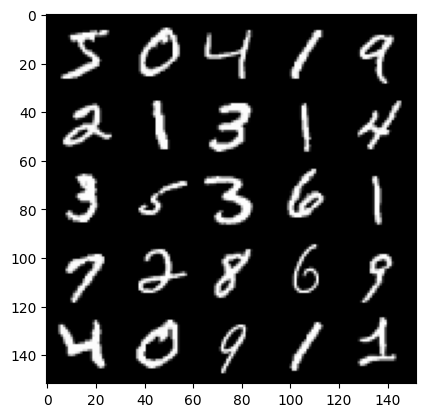

In [20]:
show_image_grid(torch.concat([extracted[0] for extracted in [mnist_dataset[i] for i in range(25)]]), 25)

In [12]:
class DcGenerator(nn.Module):

    #  1) Do a transposed convolution using the given parameters.
    #  2) Do a batchnorm, except for the last layer.
    #  3) Follow each batchnorm with a ReLU activation.
    #  4) If its the final layer, use a Tanh activation after the deconvolution.
    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
                nn.Tanh()
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )

    def __init__(self, latent_dim, hidden_dim, image_channels) -> None:
        super().__init__()

        self.latent_dim = latent_dim
        self.cnn = nn.Sequential(
            self.make_gen_block(latent_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, image_channels, kernel_size=4, final_layer=True),
        )
    
    def make_noise_shaped(self, noise):
        return noise.view(-1, self.latent_dim, 1, 1)
    
    def forward(self, noise):
        noise = self.make_noise_shaped(noise)
        return self.cnn(noise)

def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples,z_dim,device=device)


In [13]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
'''
Test your make_gen_block() function
'''
gen = DcGenerator(10, 64, 1)
num_test = 100

# Test the hidden block
test_hidden_noise = get_noise(num_test, gen.latent_dim)
test_hidden_block = gen.make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.make_noise_shaped(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
test_hidden_block_stride = gen.make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.latent_dim) * 20
test_final_block = gen.make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.make_noise_shaped(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Test the whole thing:
test_gen_noise = get_noise(num_test, gen.latent_dim)
test_uns_gen_noise = gen.make_noise_shaped(test_gen_noise)
gen_output = gen(test_uns_gen_noise)
print(gen_output.shape)


# UNIT TESTS
# try:
assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
assert hidden_output.max() > 1
assert hidden_output.min() == 0
assert hidden_output.std() > 0.2
assert hidden_output.std() < 1
assert hidden_output.std() > 0.5

assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

assert final_output.max().item() == 1
assert final_output.min().item() == -1

assert tuple(gen_output.shape) == (num_test, 1, 28, 28)
assert gen_output.std() > 0.5
assert gen_output.std() < 0.8
print("Success!")
# except: 
# print("Some of asserts have fail")

torch.Size([100, 1, 28, 28])
Success!


In [14]:
class DcDiscriminator(nn.Module):

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        #  1) Add a convolutional layer using the given parameters.
        #  2) Do a batchnorm, except for the last layer.
        #  3) Follow each batchnorm with a LeakyReLU activation with slope 0.2.
        if final_layer:
            return nn.Conv2d(input_channels, output_channels, kernel_size, stride)
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(negative_slope=0.2)
            )
        
    def __init__(self, image_channels, hidden_dim) -> None:
        super().__init__()

        self.cnn = nn.Sequential(
            self.make_disc_block(image_channels, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True)
        )

    def forward(self, x):
        x = self.cnn(x)
        return x.view(x.size(0), -1) # flatter (batch_size, 1)

In [15]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
'''
Test your make_disc_block() function
'''
num_test = 100

disc = DcDiscriminator(1, 16)
test_images = gen(get_noise(num_test, gen.latent_dim))

# Test the hidden block
test_hidden_block = disc.make_disc_block(1, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = disc.make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)

# Test the whole thing:
disc_output = disc(test_images)

In [17]:
# try:
# Test the hidden block
assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
# Because of the LeakyReLU slope
assert -hidden_output.min() / hidden_output.max() > 0.15
assert -hidden_output.min() / hidden_output.max() < 0.25
assert hidden_output.std() > 0.5
assert hidden_output.std() < 1

# Test the final block

assert tuple(final_output.shape) == (num_test, 10, 6, 6)
assert final_output.max() > 1.0
assert final_output.min() < -1.0
assert final_output.std() > 0.3
assert final_output.std() < 0.6

# Test the whole thing:

assert tuple(disc_output.shape) == (num_test, 1)
assert disc_output.std() > 0.25
assert disc_output.std() < 0.5
print("Success!")
# except:
# print("Some of asserts have fail")

Success!


In [22]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
gen_hidden_dim = 64
disc_hidden_dim = 16
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course!
beta_1 = 0.5 
beta_2 = 0.999
device = 'cpu'

In [23]:
gen = DcGenerator(z_dim, hidden_dim=gen_hidden_dim, image_channels=1).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = DcDiscriminator(image_channels=1, hidden_dim=disc_hidden_dim).to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [24]:
dataloader = DataLoader(
    mnist_dataset,
    batch_size=batch_size,
    shuffle=True)

  7%|▋         | 31/469 [00:04<01:10,  6.21it/s]

Step 500: Generator loss: 0.7189484162330627, discriminator loss: 0.6959582681655886


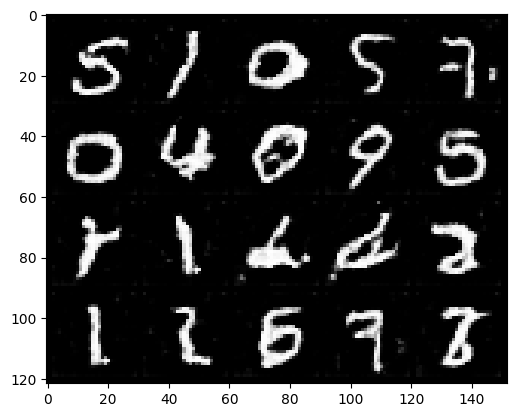

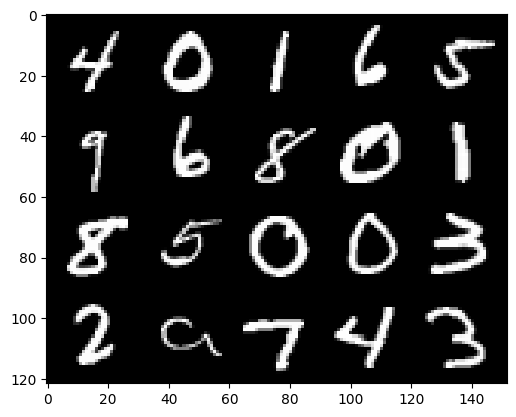

 13%|█▎        | 62/469 [00:08<00:55,  7.32it/s]

Step 1000: Generator loss: 0.712973430931568, discriminator loss: 0.6953092541694638


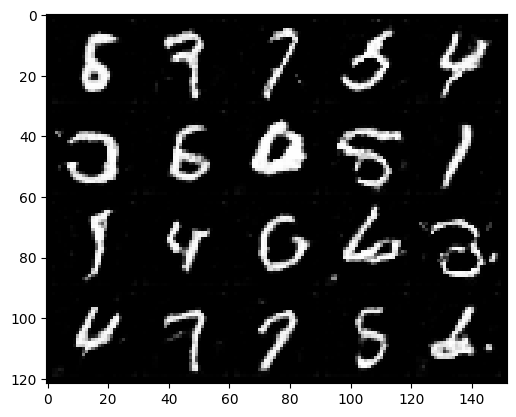

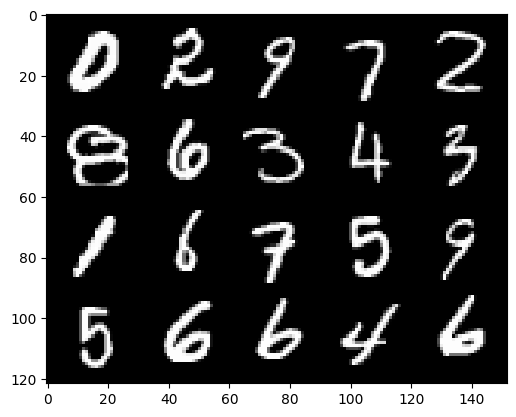

 20%|█▉        | 93/469 [00:12<00:50,  7.50it/s]

Step 1500: Generator loss: 0.7126763736605648, discriminator loss: 0.6945405420064928


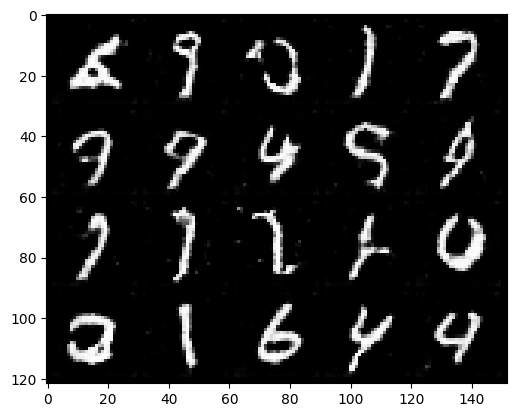

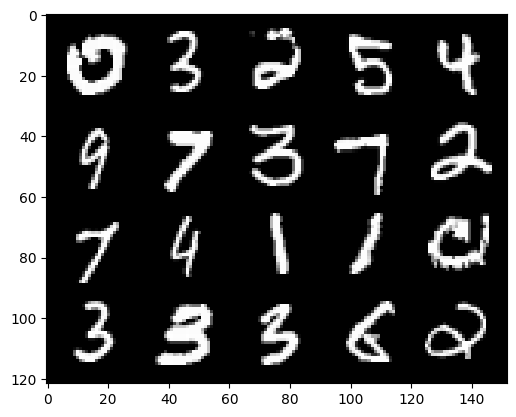

 26%|██▋       | 124/469 [00:16<00:47,  7.20it/s]

Step 2000: Generator loss: 0.7106101676821717, discriminator loss: 0.6962985590696333


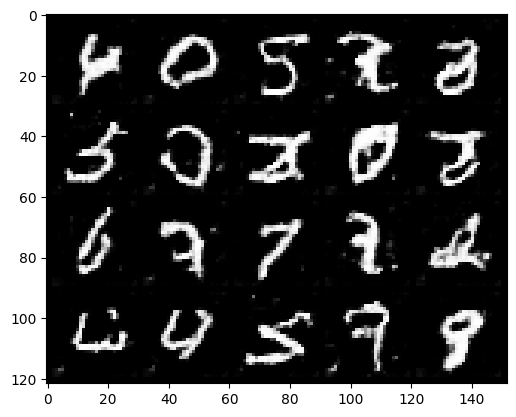

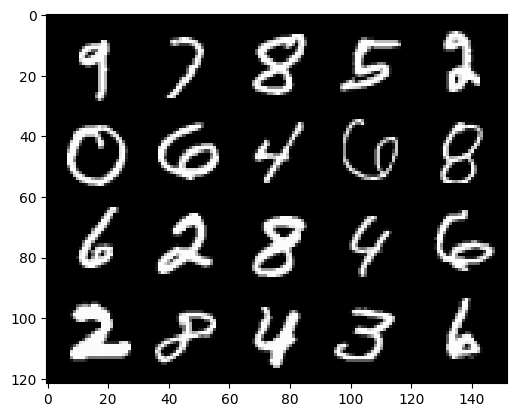

 33%|███▎      | 155/469 [00:22<00:46,  6.70it/s]

Step 2500: Generator loss: 0.7073028110265731, discriminator loss: 0.6955507178306576


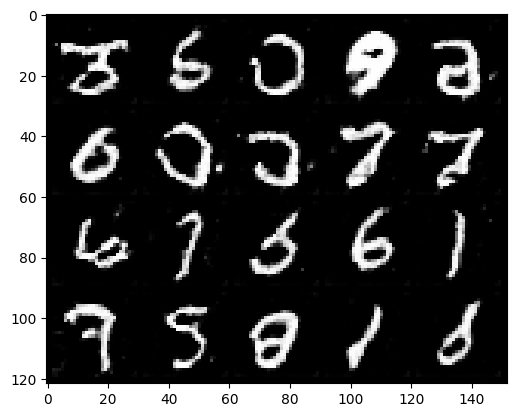

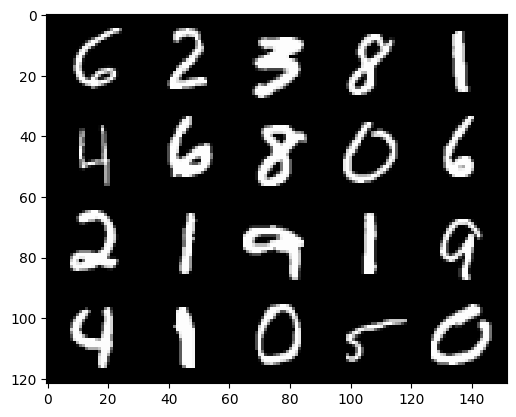

 40%|███▉      | 186/469 [00:27<00:47,  5.94it/s]

Step 3000: Generator loss: 0.708257113337517, discriminator loss: 0.6956092725992201


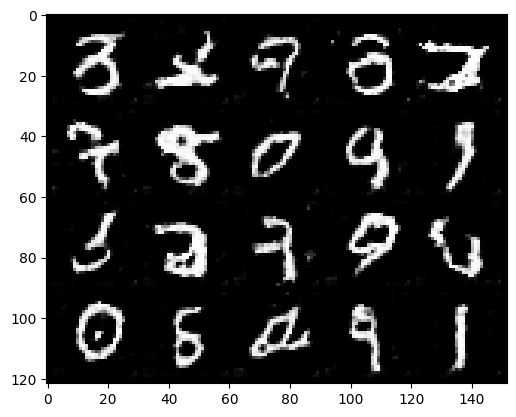

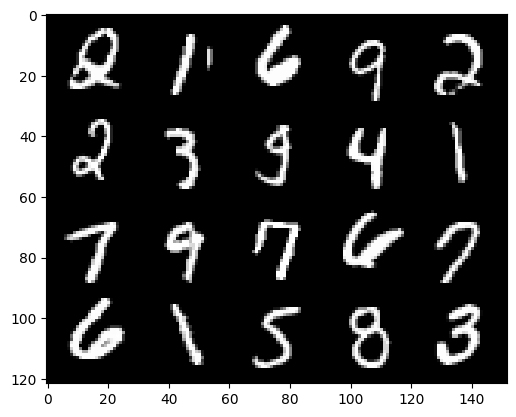

 46%|████▋     | 217/469 [00:31<00:34,  7.31it/s]

Step 3500: Generator loss: 0.7025147031545637, discriminator loss: 0.6976317791938785


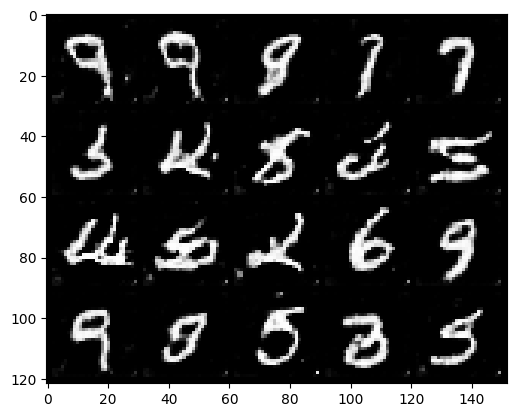

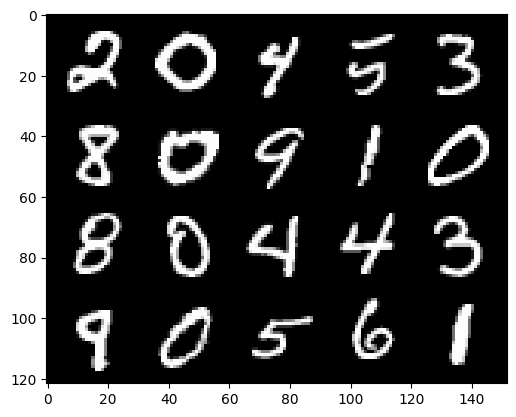

 53%|█████▎    | 248/469 [00:37<00:36,  6.07it/s]

Step 4000: Generator loss: 0.7065032536983485, discriminator loss: 0.6966342604160314


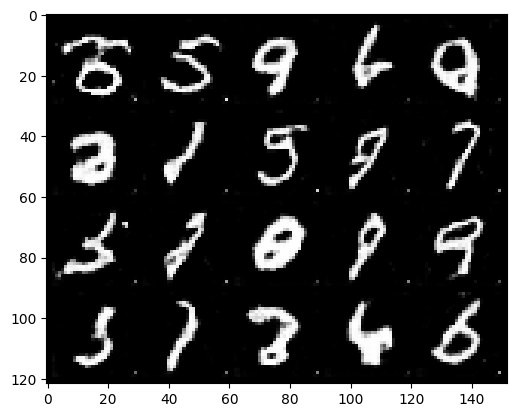

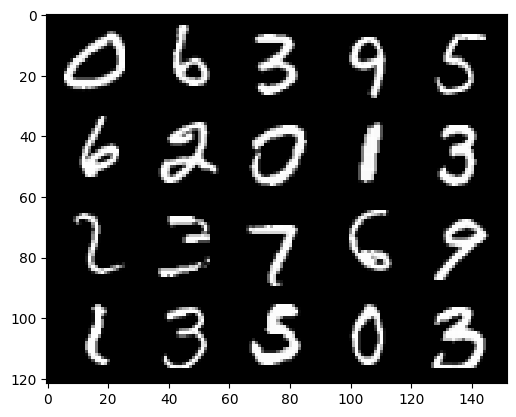

 59%|█████▉    | 279/469 [00:42<00:28,  6.64it/s]

Step 4500: Generator loss: 0.7048511091470723, discriminator loss: 0.6954419583082195


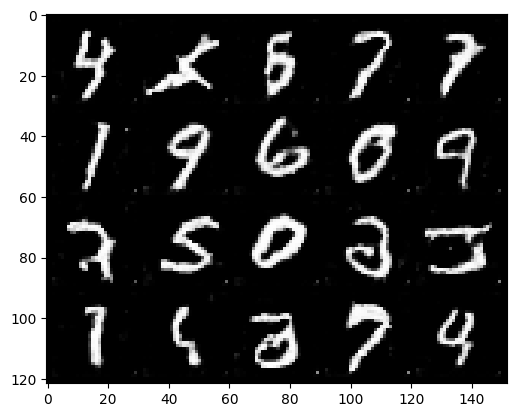

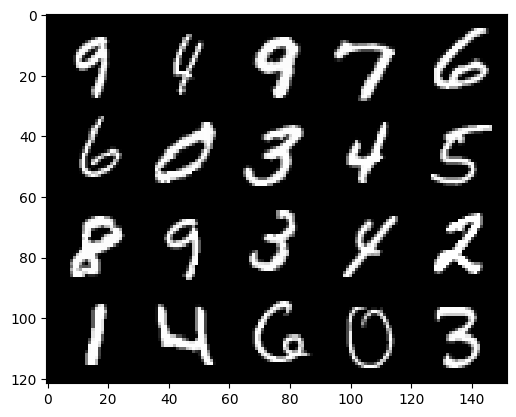

100%|██████████| 469/469 [01:11<00:00,  6.53it/s]


In [26]:
n_epochs = 10
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_image_grid(fake)
            show_image_grid(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
